<a href="https://www.kaggle.com/code/averma111/pss3e18-xgboost-lgbm-randomforest?scriptVersionId=135775003" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import  CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,mean_squared_log_error
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

In [37]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [38]:
Root_path ='/kaggle/input/playground-series-s3e18'
train = pd.read_csv(Root_path+'/train.csv')
test = pd.read_csv(Root_path+'/test.csv')

In [39]:
train.head(5)

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
0,0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,...,4.794537,35.527357,0,0,1,1,0,0,0,0
1,1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,...,13.825658,44.707310,0,0,0,1,1,0,0,0
2,2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,...,17.964475,45.660120,0,0,1,1,0,0,1,0
3,3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,...,31.961948,87.509997,0,0,1,1,0,0,0,0
4,4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,...,9.589074,33.333333,2,2,1,0,1,1,1,0


In [40]:
test.head(5)

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,14838,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
1,14839,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
2,14840,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1
3,14841,150.255712,5.912790,3.548812,3.548812,2.595128,2.595128,1.642813,0.694113,0.000000,...,59.935299,0.000000,0.000000,0.000000,17.744066,32.290168,4.794537,26.778866,0,0
4,14842,1817.276351,24.910940,15.540529,20.047314,12.535886,17.730988,11.979618,4.431173,84.554972,...,23.468091,25.609359,0.000000,37.099000,69.141353,38.704130,50.697492,102.583333,0,0


In [41]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ

In [42]:
summary('train',train)

train shape: (14838, 38)


,dtypes,null,unique,min,median,max,mean,std
id,int64,0,14838,0.000000,7418.500000,14837.000000,7418.500000,4283.505982
BertzCT,float64,0,2368,0.000000,290.987941,4069.959780,515.153604,542.456370
Chi1,float64,0,1259,0.000000,6.485270,69.551167,9.135189,6.819989
Chi1n,float64,0,3157,0.000000,4.052701,50.174588,5.854307,4.647064
Chi1v,float64,0,3306,0.000000,4.392859,53.431954,6.738497,5.866444
Chi2n,float64,0,3634,0.000000,2.970427,32.195368,4.432570,3.760516
Chi2v,float64,0,3725,0.000000,3.242775,34.579313,5.253221,4.925065
Chi3v,float64,0,3448,0.000000,1.948613,22.880836,3.418749,3.436208
Chi4n,float64,0,2930,0.000000,1.073261,16.072810,1.773472,1.865898
EState_VSA1,float64,0,719,0.000000,17.353601,363.705954,29.202823,31.728679


In [43]:
summary('test',test)

test shape: (9893, 32)


,dtypes,null,unique,min,median,max,mean,std
id,int64,0,9893,14838.000000,19784.000000,24730.000000,19784.000000,2856.007440
BertzCT,float64,0,1811,0.000000,289.901774,3919.541449,516.411916,544.327795
Chi1,float64,0,1047,0.000000,6.447265,53.876516,9.106998,6.754583
Chi1n,float64,0,2473,0.000000,4.009996,43.283925,5.848047,4.641662
Chi1v,float64,0,2604,0.000000,4.337841,53.990574,6.733659,5.863886
Chi2n,float64,0,2806,0.000000,2.930013,36.368883,4.428979,3.770031
Chi2v,float64,0,2858,0.000000,3.168052,44.726398,5.247994,4.939702
Chi3v,float64,0,2644,0.000000,1.923982,26.736931,3.401083,3.431766
Chi4n,float64,0,2249,0.000000,1.058931,15.620667,1.750078,1.837159
EState_VSA1,float64,0,582,0.000000,17.282269,363.705954,28.956335,31.470865


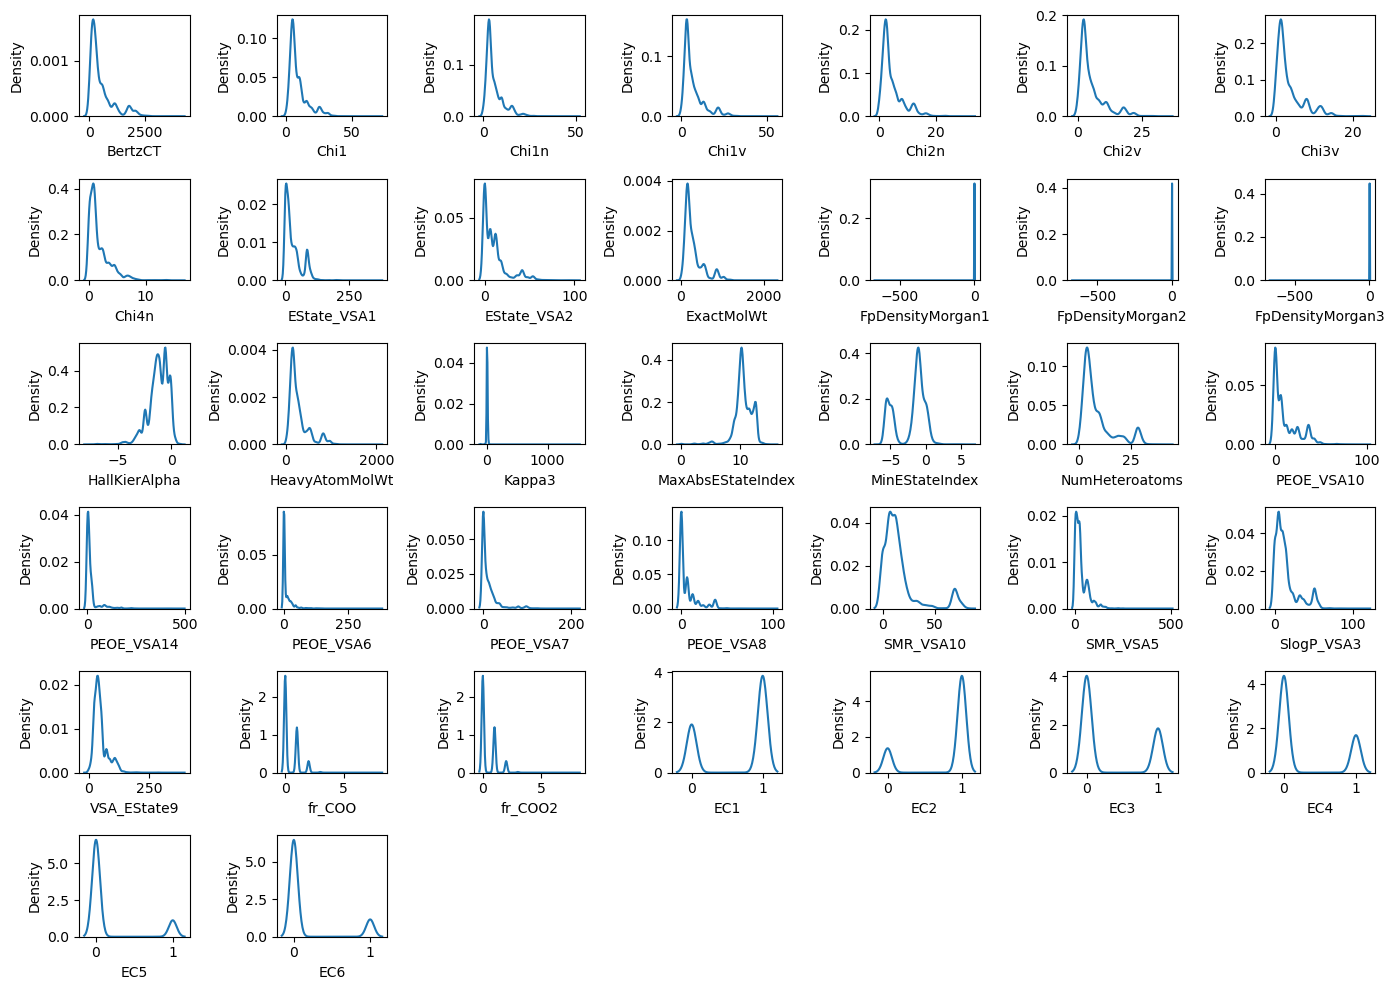

In [44]:
plt.figure(figsize=(14,10))
for i in range(1, len(train.columns)):
    plt.subplot(6,7,i)
    sns.kdeplot(x=train[train.columns[i]], label='Train Dataset')
    plt.tight_layout()

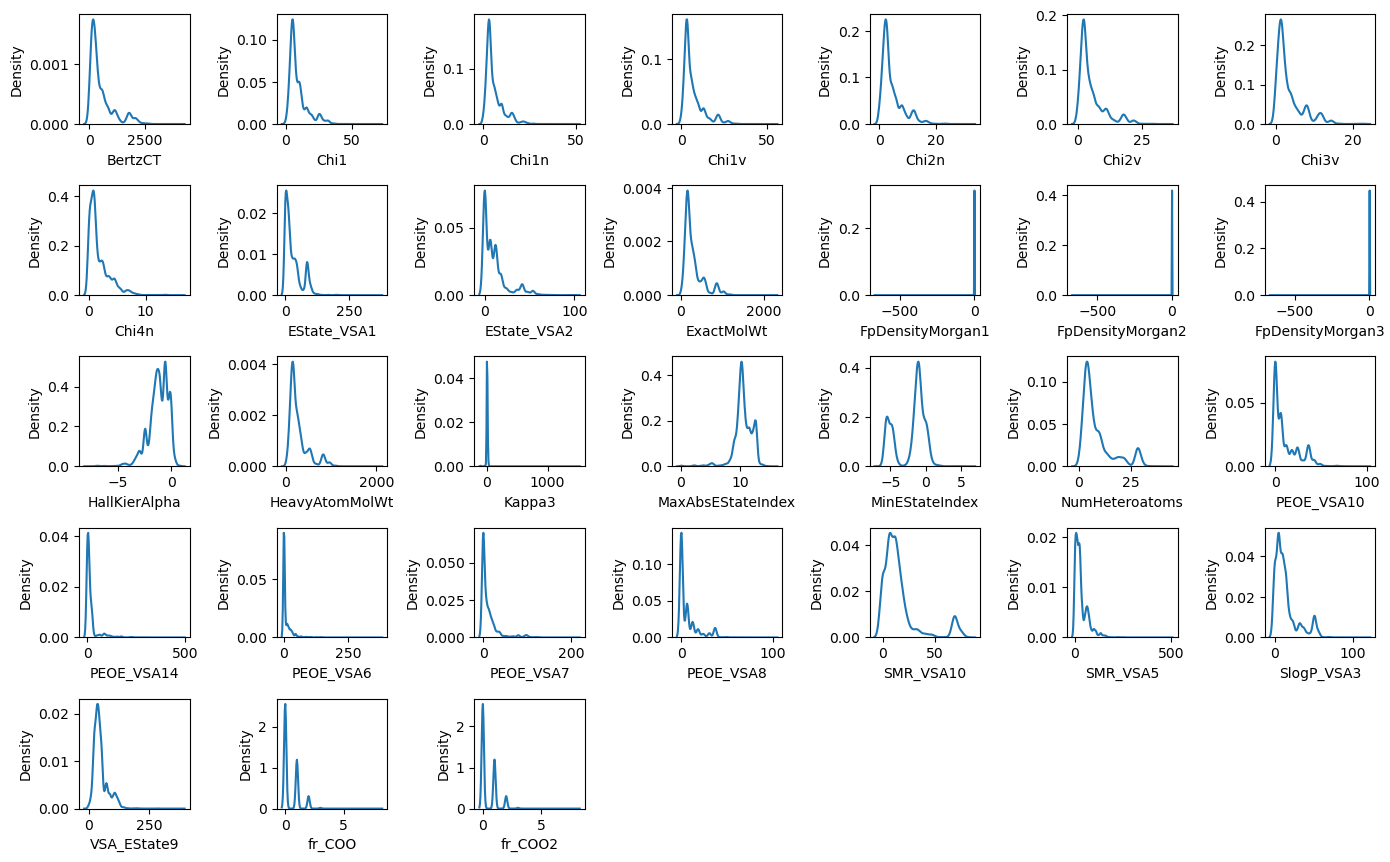

In [45]:
plt.figure(figsize=(14,10))
for i in range(1, len(test.columns)):
    plt.subplot(6,7,i)
    sns.kdeplot(x=train[test.columns[i]], label='Test Dataset')
    plt.tight_layout()

<Axes: >

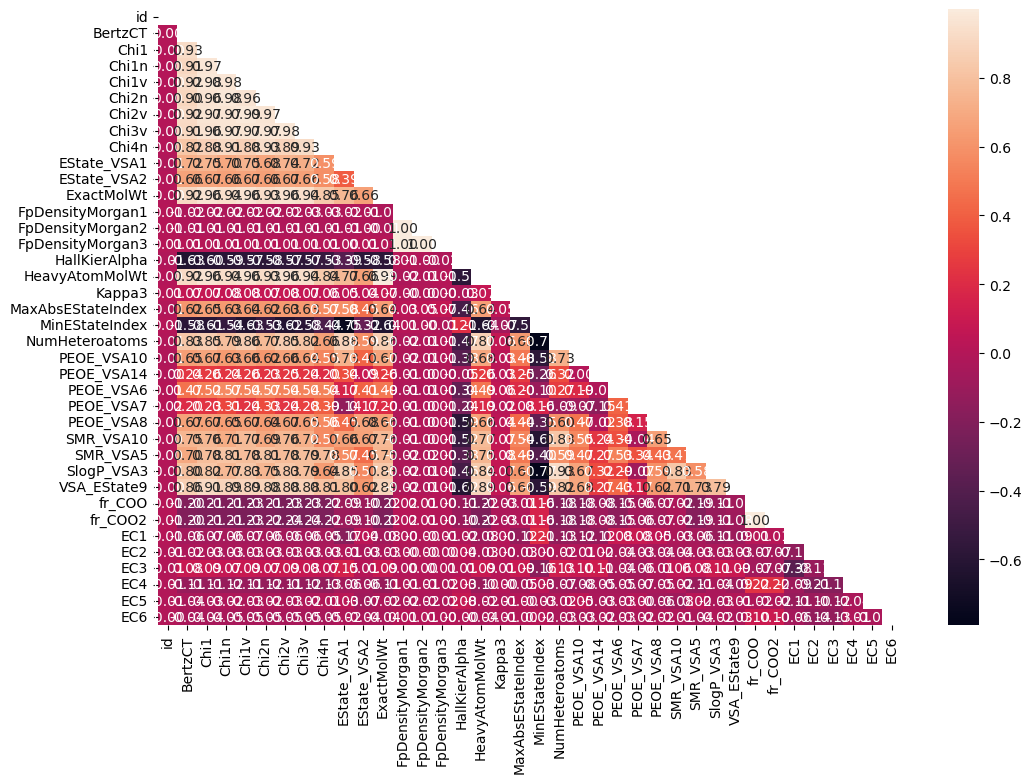

In [46]:
plt.figure(figsize=(12,8))
mask = np.triu(np.ones_like(train.corr()))
sns.heatmap(train.corr(), mask=mask, annot=True, fmt='.2f')

In [47]:
y_EC1 = train['EC1']
y_EC2 = train['EC2']
X = train.drop(columns=['id', 'EC1','EC2','EC3','EC4','EC5','EC6'])
X_test = test.loc[:, test.columns != 'id']

In [48]:
X_train,X_val,y1_train,y1_val = train_test_split(X,
                                                   y_EC1,
                                                   test_size = 0.2,
                                                   random_state = 42)
print(X_train.shape)
print(X_val.shape)
print(y1_train.shape)
print(y1_val.shape)

(11870, 31)
(2968, 31)
(11870,)
(2968,)


In [49]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)


In [50]:
model_dict = {
    'XG Boost' : XGBClassifier(),
    'Cat Boost' : CatBoostClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Lbg':LGBMClassifier()
    
   
}

In [51]:
def evaluation(model_str, y_pred, y_pred_train=y1_val):
    results = {
        'model': model_str,
        'auc score': roc_auc_score(y_pred,y_pred_train)
    }
    return results

In [52]:
result_list = []
for model in model_dict:
    model_dict[model].fit(X_train, y1_train)
    y_pred = model_dict[model].predict(X_val)
    result = evaluation(model, y_pred)
    result_list.append(result)
df_eval = pd.DataFrame(result_list)
df_eval.sort_values(by=['auc score'])

Learning rate set to 0.02963
0:	learn: 0.6863915	total: 11.5ms	remaining: 11.5s
1:	learn: 0.6800183	total: 20.1ms	remaining: 10s
2:	learn: 0.6741340	total: 28ms	remaining: 9.31s
3:	learn: 0.6684253	total: 36.4ms	remaining: 9.05s
4:	learn: 0.6632565	total: 44.3ms	remaining: 8.82s
5:	learn: 0.6582435	total: 52.6ms	remaining: 8.71s
6:	learn: 0.6537615	total: 60.9ms	remaining: 8.64s
7:	learn: 0.6493680	total: 68.8ms	remaining: 8.53s
8:	learn: 0.6453482	total: 77.3ms	remaining: 8.51s
9:	learn: 0.6414463	total: 85.4ms	remaining: 8.46s
10:	learn: 0.6378776	total: 93.4ms	remaining: 8.4s
11:	learn: 0.6346586	total: 101ms	remaining: 8.35s
12:	learn: 0.6312972	total: 110ms	remaining: 8.34s
13:	learn: 0.6280545	total: 118ms	remaining: 8.34s
14:	learn: 0.6251994	total: 127ms	remaining: 8.33s
15:	learn: 0.6224253	total: 135ms	remaining: 8.31s
16:	learn: 0.6197235	total: 144ms	remaining: 8.33s
17:	learn: 0.6171477	total: 152ms	remaining: 8.31s
18:	learn: 0.6148866	total: 161ms	remaining: 8.31s
19:	le

,model,auc score
0,XG Boost,0.606017
3,Lbg,0.634355
2,Random Forest,0.640223
1,Cat Boost,0.642431
